# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
# Initialize parameters

x = 30 # number of images you use for each video
y = 250 # final size of the input images (width)
z = 250 # final size of the input images (height)

In [5]:
def generator(source_path, folder_list, batch_size,x,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_new = imresize(image,(y,z))
                    
                    #Normalize values between [-1.0,1.0].
                    #As values for a pixel in grayscale are in range [0,255], 
                    #we needed to divide by 127.5, to bring 255 to 2.0.
                    image_normalized = image_new/127.5 -1 
                    
                    batch_data[folder,idx,:,:,0] = (image_normalized[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_normalized[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_normalized[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_new = imresize(image,(y,z))
                    
                    #Normalize values between [-1.0,1.0].
                    #As values for a pixel in grayscale are in range [0,255], 
                    #we needed to divide by 127.5, to bring 255 to 2.0.
                    image_normalized = image_new/127.5 -1 
                    
                    batch_data[folder,idx,:,:,0] = (image_normalized[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_normalized[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_normalized[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
import datetime

curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model = Sequential()

#1st Layer
model.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(30, y, z, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#2nd Layer
model.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#3rd Layer
model.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#4th Layer
model.add(Conv3D(64, #Number pf filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

# Use Dense Layer
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax')) # Since there are 5 possible gestures. Hence softmax output set to 5.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 250, 250, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 250, 250, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 250, 250, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 125, 125, 8)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 125, 125, 16)  3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 125, 125, 16)  64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 125, 125, 16)  0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size, 30,250,250)
val_generator = generator(val_path, val_doc, batch_size,30,250,250)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
model_result = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 10
Source path =  ./Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 7s - loss: 12.8517 - categorical_accuracy: 0.1877 Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 271s 4s/step - loss: 12.7178 - categorical_accuracy: 0.1964 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2020-04-1207_47_03.165125/model-00001-12.79419-0.19155-13.53920-0.16000.h5
Epoch 2/10
67/67 [==============================] - 51s 765ms/step - loss: 12.7501 - categorical_accuracy: 0.2090 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2020-04-1207_47_03.165125/model-00002-12.75014-0.20896-13.53920-0.16000.h5
Epoch 3/10
67/67 [==============================] - 51s 757ms/step - loss: 13.0709 - categorical_accuracy: 0.1891 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2020-04-1207_47_03.165125/model-00003-13.07089-0.18905-13.53920-0.16000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
67/67 [==============================] - 47s 702ms/step - loss: 13

In [13]:
import matplotlib.pyplot as plt
% matplotlib inline
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

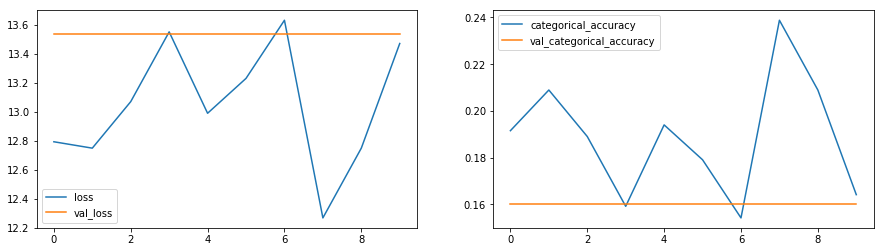

In [14]:
plot(model_result)

In [15]:
## Model 2 - Modify image Size values in x an y

In [16]:
# Initialize parameters

x = 30 # number of images you use for each video
y = 200 # final size of the input images (width)
z = 200 # final size of the input images (height)

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()

#Layer - 1
model.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(30, y, z, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer - 2
model.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer - 3
model.add(Conv3D(32, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer - 4
model.add(Conv3D(64, #Number pf filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

In [18]:
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 200, 200, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 200, 200, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 200, 200, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 100, 100, 8)   0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 100, 100, 16)  3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 100, 100, 16)  0         
__________

In [19]:
train_generator = generator(train_path, train_doc, batch_size,30,200,200)
val_generator = generator(val_path, val_doc, batch_size,30,200,200)

In [20]:
model_result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 10
Source path =  ./Project_data/train ; batch size = Epoch 1/1010



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 3s - loss: 6.6122 - categorical_accuracy: 0.2815Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 117s 2s/step - loss: 6.4641 - categorical_accuracy: 0.2796 - val_loss: 1.5766 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_2020-04-1207_47_03.165125/model-00001-6.51434-0.27903-1.57658-0.27000.h5
Epoch 2/10
67/67 [==============================] - 36s 536ms/step - loss: 1.5568 - categorical_accuracy: 0.2935 - val_loss: 1.6498 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_2020-04-1207_47_03.165125/model-00002-1.55682-0.29353-1.64976-0.30000.h5
Epoch 3/10
67/67 [==============================] - 37s 557ms/step - loss: 1.5838 - categorical_accuracy: 0.2786 - val_loss: 1.4258 - val_categorical_accuracy: 0.3400

Epoch 00003: saving model to model_init_2020-04-1207_47_03.165125/model-00003-1.58375-0.27861-1.42576-0.34000.h5
Epoch 4/10
67/67 [==============================] - 37s 558ms/step - loss: 1.5029 - categorical_accuracy: 0.3184 - val_loss: 1.4301 - val_categorical_accuracy: 0.4000

Ep

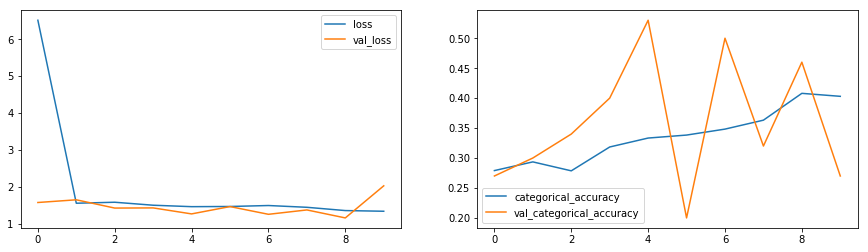

In [21]:
plot(model_result)

In [22]:
## Model 3 
# Use Optimizer SGD instead of Adam


In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model = Sequential()
#Layer - 1
model.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(30, 200, 200, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer - 2
model.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer - 3
model.add(Conv3D(32, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer - 4
model.add(Conv3D(64, #Number pf filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))


sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 200, 200, 8)   656       
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 200, 200, 8)   32        
_________________________________________________________________
activation_9 (Activation)    (None, 30, 200, 200, 8)   0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 100, 100, 8)   0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 100, 100, 16)  3472      
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_10 (Activation)   (None, 15, 100, 100, 16)  0         
__________

In [24]:
train_generator = generator(train_path, train_doc, batch_size,30,200,200)
val_generator = generator(val_path, val_doc, batch_size,30,200,200)

In [25]:
model_result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 10
Source path =  ./Project_data/train Epoch 1/10
; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 3s - loss: 12.7685 - categorical_accuracy: 0.1862Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 114s 2s/step - loss: 12.7717 - categorical_accuracy: 0.1866 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2020-04-1207_47_03.165125/model-00001-12.73691-0.18854-13.53920-0.16000.h5
Epoch 2/10
67/67 [==============================] - 35s 530ms/step - loss: 13.0709 - categorical_accuracy: 0.1891 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2020-04-1207_47_03.165125/model-00002-13.07089-0.18905-13.53920-0.16000.h5
Epoch 3/10
67/67 [==============================] - 38s 560ms/step - loss: 13.4718 - categorical_accuracy: 0.1642 - val_loss: 13.5392 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2020-04-1207_47_03.165125/model-00003-13.47184-0.16418-13.53920-0.16000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/10
67/67 [==============================] - 36s 538ms/step - loss: 12.

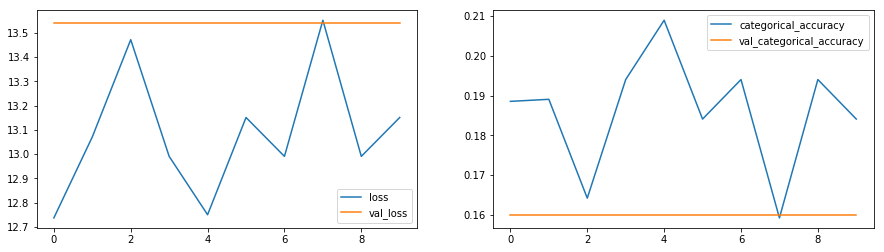

In [26]:
plot(model_result)

In [27]:
## Model : Build a CNN into RNN.


In [28]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=(30, 200, 200, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Flatten()))


model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))

model.add(Dense(250,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()
        
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 200, 200, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 200, 200, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 100, 100, 32)  4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 50, 50, 64)    18496     
__________

In [29]:
train_generator = generator(train_path, train_doc, batch_size,30,200,200)
val_generator = generator(val_path, val_doc, batch_size,30,200,200)

In [30]:
model_result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 10
Source path =  ./Project_data/train ; batch size =Epoch 1/10
 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 3s - loss: 1.7344 - categorical_accuracy: 0.2246Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 118s 2s/step - loss: 1.7241 - categorical_accuracy: 0.2288 - val_loss: 1.4163 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2020-04-1207_47_03.165125/model-00001-1.72988-0.22775-1.41631-0.43000.h5
Epoch 2/10
67/67 [==============================] - 39s 583ms/step - loss: 1.6977 - categorical_accuracy: 0.2736 - val_loss: 1.6056 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-04-1207_47_03.165125/model-00002-1.69771-0.27363-1.60561-0.23000.h5
Epoch 3/10
67/67 [==============================] - 40s 593ms/step - loss: 1.7340 - categorical_accuracy: 0.2189 - val_loss: 1.6986 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_init_2020-04-1207_47_03.165125/model-00003-1.73400-0.21891-1.69859-0.24000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
67/67 [==============================] - 39s 578ms/step - loss: 1.7245 - categ

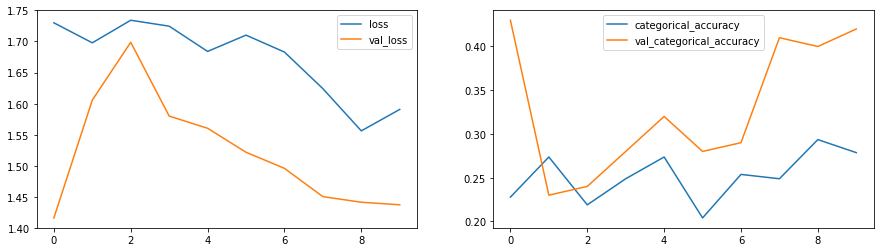

In [31]:
plot(model_result)

In [32]:
# Model : Use Optimizer as AdamDelta

In [33]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras
model = Sequential()
model = Sequential()

model.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(30, 200, 200, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, #Number pf filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))


model.compile(optimizer=keras.optimizers.Adadelta(),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 200, 200, 8)   656       
_________________________________________________________________
batch_normalization_18 (Batc (None, 30, 200, 200, 8)   32        
_________________________________________________________________
activation_13 (Activation)   (None, 30, 200, 200, 8)   0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 100, 100, 8)   0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 100, 100, 16)  3472      
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_14 (Activation)   (None, 15, 100, 100, 16)  0         
__________

In [34]:
train_generator = generator(train_path, train_doc, batch_size,30,200,200)
val_generator = generator(val_path, val_doc, batch_size,30,200,200)

In [35]:
model_result = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 10
Source path =  ./Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 3s - loss: 5.8894 - categorical_accuracy: 0.2569Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 112s 2s/step - loss: 5.7597 - categorical_accuracy: 0.2523 - val_loss: 1.5870 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2020-04-1207_47_03.165125/model-00001-5.80548-0.25490-1.58701-0.24000.h5
Epoch 2/10
67/67 [==============================] - 35s 525ms/step - loss: 1.6896 - categorical_accuracy: 0.2289 - val_loss: 1.3595 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_2020-04-1207_47_03.165125/model-00002-1.68957-0.22886-1.35953-0.31000.h5
Epoch 3/10
67/67 [==============================] - 37s 550ms/step - loss: 1.4933 - categorical_accuracy: 0.3582 - val_loss: 1.2061 - val_categorical_accuracy: 0.4300

Epoch 00003: saving model to model_init_2020-04-1207_47_03.165125/model-00003-1.49327-0.35821-1.20608-0.43000.h5
Epoch 4/10
67/67 [==============================] - 38s 563ms/step - loss: 1.5092 - categorical_accuracy: 0.3781 - val_loss: 1.3679 - val_categorical_accuracy: 0.3700

Ep

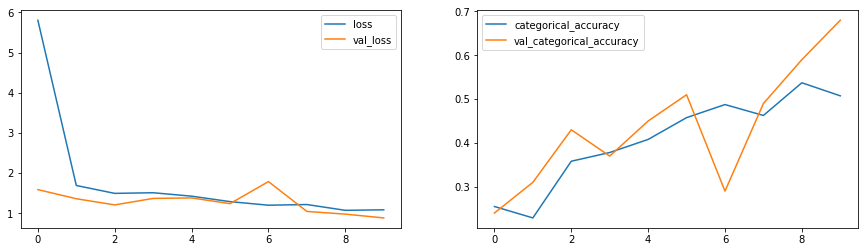

In [36]:
plot(model_result)

# Model - Transfer Learning with GRU and training all weights

In [37]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    
        
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(10, 200, 200, 3)))


model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 10, 6, 6, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 10, 6, 6, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 10, 3, 3, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 10, 9216)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               3588480   
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (D

In [38]:
train_generator = generator(train_path, train_doc, batch_size,10,200,200)
val_generator = generator(val_path, val_doc, batch_size,10,200,200)

In [39]:
model_result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Source path =  ./Project_data/val ; batch size =Source path =  ./Project_data/train ; batch size = 10
 Epoch 1/10
10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


56/67 [========================>.....] - ETA: 14s - loss: 1.7072 - categorical_accuracy: 0.2893Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 90s 1s/step - loss: 1.6671 - categorical_accuracy: 0.3005 - val_loss: 1.2948 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-04-1207_47_03.165125/model-00001-1.67062-0.30015-1.29477-0.46000.h5
Epoch 2/10
67/67 [==============================] - 26s 395ms/step - loss: 1.6847 - categorical_accuracy: 0.2836 - val_loss: 1.6139 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2020-04-1207_47_03.165125/model-00002-1.68475-0.28358-1.61390-0.25000.h5
Epoch 3/10
67/67 [==============================] - 27s 396ms/step - loss: 1.8102 - categorical_accuracy: 0.2537 - val_loss: 1.6533 - val_categorical_accuracy: 0.1500

Epoch 00003: saving model to model_init_2020-04-1207_47_03.165125/model-00003-1.81021-0.25373-1.65335-0.15000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
67/67 [==============================] - 26s 394ms/step - loss: 1.7846 - catego

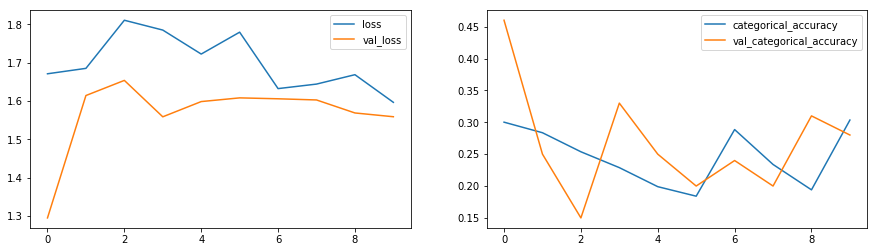

In [40]:
plot(model_result)